# Derivativos de Ações e Commodities
##  Implementando Uma Estratégia Replicante 
<sub>Uirá Caiado. 11 de Maio, 2016<sub>

#### Resumo

_Neste projeto vou implementar uma estratégia de hedging dinâmico auto-financiável que replique o payoff de diferentes derivativos. Devido à natureza aleatória do ativo objeto dos contratos testados, este será modelado como um processo estocástico. Uma vez implementado o modelo, será realizada um série de simulações para estudar a efetividade da estratégia._

## 1. Introdução

Nesta sessão dou uma breve descrição do que é uma EDE e declaro o problema que será abordado.

### 1.1. Equações Diferenciais Estocásticas

Devido à incerteza inerente ao mercado financeiro, é necessário levar em conta uma flutuação aleatória nos modelos criados para descrever diferentes instrumentos. Para tanto, frequentemente assume-se o comportamento de um ativo como sendo um [processo estocático](https://en.wikipedia.org/wiki/Stochastic_process). 

Como bem explicado neste [post](http://math.stackexchange.com/questions/1470686/in-laymans-terms-what-is-a-stochastic-process), um processo estocástico é uma maneira de representar como alguma coisa se desenvolve ao longo do tempo. A cada unidade de tempo, o ativo pode assumir uma de muitas posições possíveis, e cada uma destas posições tem uma probabilidade associada. Ainda que não seja possível antecipar qual trajeto o ativo vai seguir, é possível inferir quais caminhos são possíveis baseado nesta dinâmica.

Processos estocásticos são de grande valia quando não se sabe exatamente as regras que regem esta evolução ou quando extrair tais regras com exatidão ou é muito complicado ou muito caro computacionalmente. Assim, frequentemente se utiliza alguma fonte de aleatoriadade para ajudar a descrever a dinâmica de um ativo. Aqui entram as EDEs. \cite{Wilmont} oferece a seguinte intuição sobre a forma geral de Equações Diferenciais Estocásticas (EDE):

$$\mathrm{d}\, Alguma\,Coisa = Deterministico\,\mathrm{d}t + Aleatório\,\mathrm{d}X $$


Onde $Alguma\,Coisa$ é o que se quer modelar (como preço de uma ação, quantidade de pessoas chegando em um hospital e etc), $Deterministico$ uma função que descreve como  $Alguma\,Coisa$ muda quando se retira a incerteza e $Aleatório$ outra função que descreve quão incerto $Alguma\,Coisa$ coisa é e $X$ é uma variável aleatória que pode ter distribuição Normal Padrão, por exemplo.

### 1.1. O Problema

Considerando um ativo-objeto cujo a dinâmica do preço satisfaz a seguinte EDE:

$$\frac{\mathrm{d} S_t}{S_t}=\mu\cdot \mathrm{d}t + \sigma\cdot \mathrm{d}W_{t}$$

Será vendido um derivativo com característica européia cujo payoff é descrito por uma função qualquer $V_T=V(T, S_T)$, onde $T$ é o vencimento do derivativo. $S_T$ é o preço do ativo-objeto em $T$ e é possível negociar qualquer quantidade dele em qualquer instante. Não há custo de transação (corretagem, emolumento, bid-ask spread, etc) e posições vendidas a descoberto no subjacente são permitidas, não havendo custos associados.

Pede-se que se implemente uma estratégia dinâmica de hedging auto-financiável que replique o payoff do derivativo vendido. A estratégia replicante será rebalanceada $N$ vezes (incluíndo a carteira inicial).

A simulação deve ser feita para os payoffs abaixo. $K$ é o Strike da opção.
- $V(T, S_T)=ln(S_T)$
- $V(T, S_T)=(ln(S_T))^2$
- $V(T, S_T)=(S_T-K)^2$
- $V(T, S_T)=\mathbf{1}_{S_T > K}$
- $V(T, S_T)=max(S_T-K, 0)$


## 2. Simulando o Ativo Base

Para realizar a simulação, implementarei o processo estocástico do ativo-objeto, que segue um Movimento Browniano Geométrico. Desta forma, preciso discretizar o processo e tenho duas opções para isso: ou encontro a solução para a EDE porposta, que resultará no [processo estocástico desejado](https://en.wikipedia.org/wiki/Geometric_Brownian_motion); ou uso [método de Euler](http://www.columbia.edu/~mh2078/MCS04/MCS_SDEs.pdf). O último, apesar de ser apenas uma aproximação do processo, tem a a vantagem de poder ser aplicada à qualquer Equação diferencial Estocástica (\cite{Wilmont}). Nas próximas subseções vou demonstrar e implementar cada modelo. 

### 2.1. A Solução Exata do Modelo

Seguindo as notas de aula e reescrevendo a dinâmica por conveniência, tenho que

\begin{equation}
    \begin{aligned}
    \frac{\mathrm{d} S_t}{S_t} &= \mu\cdot \mathrm{d}t + \sigma\cdot \mathrm{d}W_{t}
    \end{aligned}
\end{equation}


Que corresponde a forma derivada da integral estocástica:


\begin{equation}
    \begin{aligned}
    \int_{t}^{T}{\frac{\mathrm{d} S_t}{S_t}} &= \int_{t}^{T}{\mu\cdot \mathrm{d}t} + \int_{t}^{T}{\sigma\cdot \mathrm{d}W_{t}} 
    \end{aligned}
\end{equation}



Considerando o [Teorema de Ito-Doeblin](https://en.wikipedia.org/wiki/Itô%27s_lemma) (Lemma de Ito) sendo da forma abaixo

\begin{equation}
    \begin{aligned}
    \mathrm{d} f(t, S_t) = \frac{\mathrm{\partial} f}{\partial t} \mathrm{d} t + \frac{\mathrm{\partial} f}{\partial S_t} \mathrm{d} S_t + \frac{1}{2} \frac{\mathrm{\partial^2} f}{\mathrm{\partial} S_{t}^{2}} (\mathrm{d} S_t)^2
    \end{aligned}
\end{equation}

Se definir uma função $f(S_t) = ln(S_t)$, posso aplicar o Lema de Ito sobre ela. Dado que $(\mathrm{d} t)^2 = \mathrm{d} t \cdot \mathrm{d} X = 0$, e que $(\mathrm{d} S_t)^2 = \sigma^2  \cdot S_{t}^{2} \cdot \mathrm{d} t$. Como não há termos dependentes de $t$ em $f$, não precisarei do termo relacionado a $\mathrm{d} t$. Assim ficou com:

\begin{equation}
    \begin{aligned}
    \mathrm{d} f(t, S_t) &= \frac{\mathrm{\partial} f}{\partial S_t} \mathrm{d} S_t + \frac{1}{2} \frac{\mathrm{\partial^2} f}{\mathrm{\partial} S_{t}^{2}} (\mathrm{d} S_t)^2 \\
    &= \frac{1}{S_t} \cdot \mathrm{d} S_t - \frac{\sigma^2}{2} \cdot S_{t}^{2} \cdot \frac{1}{S_{t}^{2}} \cdot  \mathrm{d} t 
    \end{aligned}
\end{equation}

Integrando dos instantes $t$ até $T$, obtenho:

\begin{equation}
    \begin{aligned}
    \int_{t}^{T} \mathrm{d} f(t, S_t) &= \int_{t}^{T} \frac{1}{S_t} \cdot \mathrm{d} S_t - \int_{t}^{T} \frac{\sigma^2}{2} \cdot \mathrm{d} t \\
    \int_{t}^{T} \frac{\mathrm{d} S_t}{S_t} &= \int_{t}^{T} \mathrm{d} f(t, S_t) + \int_{t}^{T} \frac{\sigma^2}{2} \cdot \mathrm{d} t \\
    &= f(S_T) - f(S_t) + \frac{\sigma^2}{2} \cdot (T - t) \\
    &= ln(S_T) - ln(S_t) + \frac{\sigma^2}{2} \cdot (T - t) \\
    &= ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t)
    \end{aligned}
\end{equation}

Logo, substituíndo este resultado na integral estocástica da dinâmica da ação, chego que:

\begin{equation}
    \begin{aligned}
    ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \int_{t}^{T}{\mu\cdot \mathrm{d}t} + \int_{t}^{T}{\sigma\cdot \mathrm{d}W_{t}} \\
     ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \mu\cdot (T - t) + \sigma \cdot (W_{T} - W_{t})
    \end{aligned}
\end{equation}

Por fim, lembrando que o $W_t$ é um processo de Winer e possui incrementos independentes, estacionários e distribuição $N(0, t)$ por definição, posso considerar que $W_t - W_s = W_{t-s}$. Termino com:

\begin{equation}
    \begin{aligned}
     ln(S_T/S_t) + \frac{\sigma^2}{2} \cdot (T - t) &= \mu\cdot (T - t) + \sigma \cdot W_{T-t} \\
     ln(S_T/S_t) &= \left (\mu - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W_{T-t} \\
     S_T &= S_t \cdot e^{ \left (\mu - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W_{T-t}}
    \end{aligned}
\end{equation}

Onde $W_{T-t} = \sqrt{T-t} \cdot \epsilon_t$. A última equação é a solução exata desta EDE e poderia ser utilizada na simulação. Abaixo, vou implementa-la e testá-la.

In [4]:
# bibliotecas necessarias
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [24]:
class StochasticProcess(object):
    '''
    A general representation of a Stochastic Process
    '''
    def __init__(self, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a StochasticProcess object. Save all parameters as attributes
        '''
        self._f_sigma = 0
        # guarda parametros
        self.f_sigma = f_sigma
        self.f_time = f_time
        self.f_steps = f_steps
        self.b_random_state = b_random_state
        # checa se seta um seed para o random state
        if not b_random_state:
            np.random.seed(0)
    
    @property
    def f_sigma(self):
        '''
        Return the variance of the process
        '''
        return self._f_sigma
    
    @f_sigma.setter
    def f_sigma(self, f_value):
        '''
        set the f_sigma attribute. ensure that the number is positive
        :param f_value: float. A non negative float number
        '''
        # TODO: I need to check this property
        assert f_value>=0., u"A volatilidade deve ser positiva"
        self._f_sigma = f_value
        
    def _random_number(self):
        '''
        Return a float drown from a distribution
        and standard deviation 1
        '''
        raise NotImplementedError()
    
    def __call__(self):
        '''
        Return a random drow from the Stochastic Process
        '''
        raise NotImplementedError()
    

In [25]:
class WienerProcess(StochasticProcess):
    '''
    A representation of a Wiener process, also called Brownian motion.
    '''
    def __init__(self, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a WienerProcess object. Save all parameters as attributes
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        super(WienerProcess, self).__init__(f_sigma, f_time, f_steps, b_random_state = True)
    
    def _random_number(self):
        '''
        Return a float of drown from a normal distribution with mean 0 and standard
        deviation 1
        '''
        return np.random.standard_normal()
    
    def __call__(self):
        '''
        Return a random drow from the Wiener process with mean 0 and variance t
        '''
        delta_t = self.f_time/self.f_steps
        sqrt_delta_sigma = math.sqrt(delta_t) * self.f_sigma
        return sqrt_delta_sigma * self._random_number()

In [26]:
class GeometricBrownianMotion(StochasticProcess):
    '''
    A generic representation of a Geometric Brownian Motion (GBM). Besides de variance,
    this process might present a drift
    '''
    def __init__(self, f_s0, f_sigma, f_time, f_steps, b_random_state=True, f_r=None, f_mu=None):
        '''
        Initialize a GeometricBrownianMotion object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        :*param f_r: float. risk free interest rate
        :*param f_mu: float. the average return of the process
        '''
        # inicia parametros
        self._original = f_s0
        self.f_St = f_s0
        self.f_mu = f_mu
        self.f_r = f_r
        self._current_step = -1
        super(GeometricBrownianMotion, self).__init__(f_sigma, f_time, f_steps,
                                                      b_random_state = True)
        # inicia o processo de winner presente no BGM
        self.wiener_process = None
  
    @property
    def current_step(self):
        '''
        Return the variance of the process
        '''
        return self._current_step
    
    @current_step.setter
    def current_step(self, i_value):
        '''
        set the current_step attribute. ensure that the current step is
        not greater than the total steps defined to the process
        :param i_value: integer. A increment step to the current path
        '''
        self._current_step = i_value
        if self._current_step > self.f_steps:
            self._current_step = 0
            self.f_St = self._original
        
        
    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by a
        Geometric Brownian Motion
        '''
        raise NotImplementedError()

In [31]:
class GBM_Exact_Solution(GeometricBrownianMotion):
    '''
    A representation of the Exact solution of a Geometric Brownian Motion (GBM).
    Besides de variance, this process might present a drift
    '''
    def __init__(self, f_s0, f_mu, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a GBM_Exact_Solution object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_mu: float. the average return of the process
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        # inicia variaveis da GeometricBrownianMotion
        super(GBM_Exact_Solution, self).__init__(f_s0 = f_s0,
                                                 f_mu = f_mu,
                                                 f_sigma = f_sigma,
                                                 f_time = f_time,
                                                 f_steps = f_steps,
                                                 b_random_state = True)
        # inicia o processo de winner presente no BGM
        self.wiener_process = WienerProcess(f_sigma, f_time, f_steps)      
        
    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by the
        Exact solution of the Geometric Brownian Motion
        '''
        # seta a quantidade de passos ja dados por esse processo
        # se for maior que limite, retorna para estado inicial e
        # comeca novamente
        self.current_step += 1
        s_entrei = "Nao"
        if self.current_step > 0:
            s_entrei = "Sim"
            # calcula preco pelo movimento browniano geometrico
            dt = self.f_time/self.f_steps
            sigma_pow_mu_delta = (self.f_mu - 0.5 * self.f_sigma**2.0) * dt
            f_log_rtn = sigma_pow_mu_delta + self.wiener_process()
            f_rtn = np.exp(f_log_rtn)
            self.f_St *= f_rtn
            # print self.current_step, self.f_St, s_entrei
        return self.f_St

In [49]:
import time

def do_simulations(MySrochasticProcess, i_nsiml, f_s0, f_mu, f_sigma, f_time, f_steps, f_r=None):
    '''
    Simulate a number of paths using some Stochastic Process and return a dataframe
    with all paths
    :param MySrochasticProcess: StochasticProcess object. The stochastic process used
    :param i_nsiml: integer. the number of paths contructed
    :param f_s0: float. The initial price of the process
    :param f_mu: float. the average return of the process
    :param f_sigma: float. The standard deviation of ALL distribution
    :param f_time: float. the time at each step, in years
    :param f_steps: float. number of steps to simulate for
    '''
    st = time.time()
    # Crio objeto para simulacao
    if f_r:
        gbm = MySrochasticProcess(f_s0=f_s0,
                                 f_r=f_r,
                                 f_sigma=f_sigma,
                                 f_time=f_time,
                                 f_steps=f_steps)
    else:
        gbm = MySrochasticProcess(f_s0=f_s0,
                                 f_mu=f_mu,
                                 f_sigma=f_sigma,
                                 f_time=f_time,
                                 f_steps=f_steps)
    # crio i_nsiml caminhos com f_steps simulacoes
    l = []
    l_aux = []
    for idx in range(int(i_nsiml * (1 + gbm.f_steps))):
        if gbm.current_step==gbm.f_steps:
            l.append(l_aux)
            l_aux = []
        l_aux.append(gbm())
    l.append(l_aux)
    # imprimo tempo e simulacoes
    print ("\nNumero de sorteios: {}".format(idx + 1))
    print ("Levou {:0.2f} segundos".format(time.time() - st))
    # crio dataframe com os passos nas linhas e as simulacoes nas colunas
    df = pd.DataFrame(l).T
    return df

In [44]:
def plot_simulations(df, s_title, f_steps):
    '''
    Plot a line chart to each path in the dataframe passed
    and a vertical histogram summarizing all paths
    :param df: dataframe. the data with all paths simulated
    :param s_title: string. The title of the chart
    :param f_steps: float. the number of steps in the simulation
    '''
    # crio o grid
    sns.set_context(rc={"figure.figsize": (15, 6)})
    g = sns.JointGrid(x=df.columns, y=df.iloc[-1, :].values, size=7)
    g.ax_marg_x.set_visible(False)
    # ploto as linhas
    g.ax_joint.plot(df, linewidth=2)
    g.ax_joint.set_xlim([0, int(f_steps)])
    # ploto o histograma
    g.plot_marginals(sns.distplot, kde=True)
    # arrumo o grafico
    g.fig.suptitle(s_title, fontsize=18, y=0.92)
    g.set_axis_labels("Passo", u"Preço");

Abaixo vou plotar 500 caminhos, cada um com 15 passos. Vou mostrar visualmente as primeiras linhas da matriz criada a checagem.

In [59]:
d_param = {"f_s0": 10.,  # estado inicial do ativo
           "f_mu": 0.25,  # media da dinamica
           "f_sigma": 0.15,  # desvio padrao da dinamica
           "f_time": 0.5,  # tempo decorrido na simulacao
           "f_steps": 15, # quantidade de passos dado entre a e f_time
           "f_r": None  # taxa de juros
           }  
df = do_simulations(GBM_Exact_Solution, 500, **d_param)
df.head()


Numero de sorteios: 8000
Levou 0.08 segundos


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
1,9.953325,9.867565,9.815663,9.753335,9.670364,10.206224,10.642176,10.423072,10.265523,9.957987,...,9.866211,9.670278,9.779993,10.265011,9.956412,10.244876,10.118531,9.876715,9.951347,10.382046
2,10.470267,10.010729,9.664556,9.741535,9.859107,10.165574,10.341405,10.063938,10.137311,9.942244,...,9.970751,10.098001,10.047144,10.073303,9.952539,10.196358,10.438396,10.014777,10.297614,10.360561
3,10.909596,10.048900,9.481382,10.154960,9.813546,10.343919,10.101760,10.587078,10.162501,10.105705,...,9.675041,10.105352,10.663421,10.201150,10.304934,9.960579,10.697478,9.684596,10.831361,9.767487
4,10.662497,10.311641,9.216933,9.891462,10.473155,10.330820,9.634962,10.596793,10.370451,10.194576,...,9.610290,10.577949,10.609636,10.307924,10.745799,9.971268,10.646128,9.920190,11.367422,10.030394


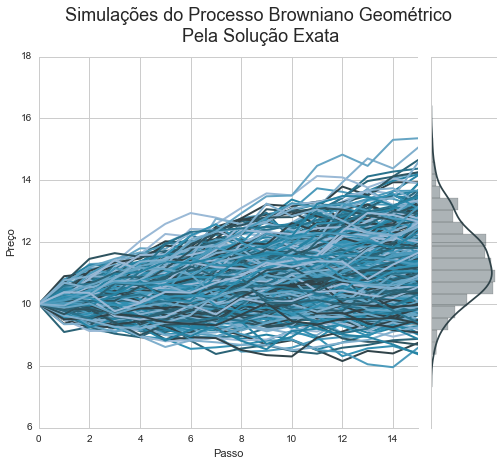

In [60]:
plot_simulations(df,
                 u"Simulações do Processo Browniano Geométrico\n Pela Solução Exata",
                 d_param["f_steps"])

In [61]:
# mostra resumo estatistico do ultimo valor das simulacoes
df_descr = pd.DataFrame(df.iloc[-1, :].describe()).T
df_descr.index = ["values"]
df_descr

,count,mean,std,min,25%,50%,75%,max
values,500,11.365979,1.183551,8.374308,10.541332,11.292843,12.086871,15.357905


Aparentemente a implementação ficou correta e, apesar de estar simulando um passo por vez e dividido todo processo em diferentes classes, o tempo necessário para rodar toda a simulação ficou em um nível aceitável (cerca de 80 milisegundos). Abaixo, vou utilizar toda a estrtutura criada nesta subseção para fazer a simulação pelo método de Euler.


### 2.2. Implementação da Solução Aproximada Pelo Método de Euler

Em aplicações reais, muitas vezes a equação estocástica pode não ter uma solução explícita ou podemos ter dificuldade em determinar os parâmetros do modelo e/ou a distribuição de $W_{t}$. Assim, muitas vezes recorre-se ao método de Euler para discretizar o processo. Neste caso, o método é da forma:

\begin{equation}
    \begin{aligned}
    \hat{X}_{t_{i+1}} = \hat{X}_{t_{i}} + b(t, \hat{X}_{t_i}) \cdot h_i + \sigma(t_i, \hat{X}_{t_i}) \cdot \sqrt{h_i} \cdot \epsilon_i\\
    \left\{\begin{matrix}
        b(t, \hat{X}_{t_i}) &= \mu S_{t_{i}}\\ 
        \sigma(t_i, \hat{X}_{t_i}) &= \sigma S_{t_{i}}\\ 
        h_i &= t_{i+1} - t_i
    \end{matrix}\right.
    \end{aligned}
\end{equation}

Sendo que $\epsilon$ é uma variável aleatória com distribuição normal padrão. Abaixo vou implementar e testar este método

In [65]:
class GBM_By_Euler(GeometricBrownianMotion):
    '''
    A representation of the Geometric Brownian Motion (GBM) simulated using Euler
    Method. Besides de variance, this process might present a drift
    '''
    def __init__(self, f_s0, f_mu, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a GBM_Exact_Solution object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_mu: float. the average return of the process
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        # inicia variaveis da GeometricBrownianMotion
        super(GBM_By_Euler, self).__init__(f_s0=f_s0,
                                           f_mu=f_mu,
                                           f_sigma=f_sigma,
                                           f_time=f_time,
                                           f_steps=f_steps)
        # inicia o processo de winner, que vou dar o nome dos termos da equacao
        self.sigma_sqrt_t_eps = WienerProcess(f_sigma * f_s0, f_time, f_steps)

    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by a
        Geometric Brownian Motion
        '''
        # seta a quantidade de passos ja dados por esse processo
        # se for maior que limite, retorna para estado inicial e
        # comeca novamente
        self.current_step += 1
        if self.current_step > 0:
            # calcula preco pelo movimento browniano geometrico
            dt = self.f_time/self.f_steps
            mu_St_dt = self.f_mu * self.f_St * dt
            sigma_St_sqrt_t_eps = self.f_St * self.sigma_sqrt_t_eps()
            self.f_St += mu_St_dt + sigma_St_sqrt_t_eps
            # print self.current_step, self.f_St, s_entrei
        return self.f_St

Realizando o teste com os mesmos parâmetros da simulaçâo anterior, obtenho os seguintes resultados:

In [66]:
d_param = {"f_s0": 10.,  # estado inicial do ativo
           "f_mu": 0.25,  # media da dinamica
           "f_sigma": 0.15,  # desvio padrao da dinamica
           "f_time": 0.5,  # tempo decorrido na simulacao
           "f_steps": 15, # quantidade de passos dado entre a e f_time
           "f_r": None  # taxa de juros
           }
df = do_simulations(GBM_By_Euler, 500, **d_param)
df.head()


Numero de sorteios: 8000
Levou 0.05 segundos


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
1,9.811180,-0.293780,9.676627,8.527101,12.307008,11.081821,6.788048,8.994219,11.145730,7.290331,...,14.058888,8.510781,13.216440,9.086957,10.379996,7.608593,8.626879,7.950760,14.162567,7.972422
2,11.660632,-0.223954,10.376477,6.471111,19.567401,14.384724,6.610923,10.063971,12.285884,6.912243,...,13.794688,11.438010,11.403653,5.982705,9.243511,8.420265,10.184081,9.207021,18.558470,6.333827
3,9.530854,-0.206552,8.560101,2.697029,27.498078,14.245838,9.188646,12.898590,7.350986,8.344968,...,17.387598,10.801458,16.364946,9.065911,6.133826,9.865282,7.817448,13.726012,7.747407,6.908848
4,8.569844,-0.251132,8.470242,2.588494,29.701902,8.248860,7.691982,15.403906,11.695758,8.929157,...,22.148995,8.996065,13.081900,5.022968,9.500225,13.430489,6.494137,14.763987,10.352863,4.000472


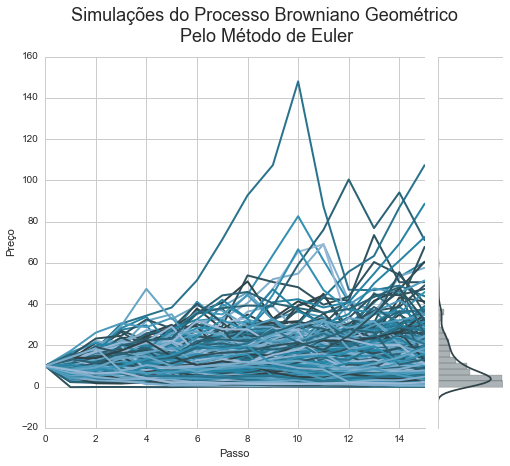

In [67]:
plot_simulations(df,
                 u"Simulações do Processo Browniano Geométrico\n Pelo Método de Euler",
                 d_param["f_steps"])

In [68]:
# mostra resumo estatistico do ultimo valor das simulacoes
df_descr = pd.DataFrame(df.iloc[-1, :].describe()).T
df_descr.index = ["values"]
df_descr

,count,mean,std,min,25%,50%,75%,max
values,500,11.051578,12.846349,-0.096194,3.038945,6.429584,14.72911,107.328048


A distribuição final dos valores ficou suficientemente parecida e este método é muito mais genérico e fácil de usar do que resolver uma EDE. Além disso, esta simulação foi um pouco mais rápida que o anterior. Utilizarei o método de Euler quando for implementar a estratégia de replicação. **Um ponto interessante a se notar nas simulações que elas ficaram deslocadas um pouco para cima, o que é esperado, dado que existe um drift na dinâmica**.

## 3. Precificando Opções

Segundo \cite{Wilmont}, o valor justo de uma opção pode ser mostrado como sendo o payoff esperado em seu vencimento. Porém, não o valor sob a expectativa real, que considera a probabilidade real (e geralmente desconhecida) de diferentes eventos acontecerem, mas sim uma outra, [neutra a risco](https://en.wikipedia.org/wiki/Risk-neutral_measure). Assim, espera-se que:

$$preço\, da\, opção = e^{-r(T-t)} \cdot \tilde{E}[payoff(S_T)]$$

Onde $e^{-r(T-t)}$ é o fator de desconto. Nesta seção vou demonstrar rapidamente alguns conceitos importantes no [método de Martingale](https://en.wikipedia.org/wiki/Martingale_pricing) de precificação de opções e implementar as classes necessárias para calcular o preço de cada opção desejada. 

### 3.1. Martingale e Não-Arbitragem

É dito que uma dada sequência de variáveis aleatórias é Martingale quando, em um dado momento, a expectativa sobre o próximo valor dela é o valor observado neste momento. Por tanto, um processo é martingale se 

$$M_n = E_n [M_{n+1}],\qquad n = 0, 1, ..., N-1$$

Quando se precifica uma opção, é interessante que seu subjacente apresente esta característica pois isso é o equivalente a dizer que não é possível a realização de arbitragem utilizando a opção precificada e o ativo no qual ela se baseia.

Como observado nas simulações,  a média da dinâmica ficou ligeiramente deslocada de seu valor original. Isso ocorreu devido sua espectativa ser [dada](http://www.math.unl.edu/~sdunbar1/MathematicalFinance/Lessons/StochasticCalculus/GeometricBrownianMotion/geometricbrownian.pdf) por $E^{P} [S_t] = S_0 e^{(\mu - \tfrac{\sigma^2}{2})t}$, onde $P$ denota que está sendo utilizada a probabilidade real ( lembrando que $E[W_t] = 0$). Pensando em não-arbitragem, é necessário encontrar uma maneira de se mudar o drift da dinâmica da dinâmica para $r$. Assim, quando se trazer o preço a valor presente se obterá um Martingale.

### 3.2. Mudança de Medida

Para se realizar a mudança de medida necessária para alterar o drift da dinâmica, utiliza-se o [teorema de Girsanov](https://en.wikipedia.org/wiki/Girsanov_theorem). Assim, seguindo notas de aula, tenho

$$\mathrm{d} \tilde{W_t} = \mathrm{d} W_t - X_t \mathrm{d}t$$

Onde $\mathrm{d} W_t$ é um processo de Wiener com relação à medida de probabilidade $P$ e  $\mathrm{d} \tilde{W_t}$ é martingale com relação à medida $\tilde{P}$. A váriável aleatória $X$ é uma função qualquer. Assim, considerando que:

$$\tilde{P}(A) = E^{P}[1_A \xi_{t}] = \int_{\Omega}^{} 1_A \xi_t \mathrm{d} P = \int_{A}^{} \xi_t \mathrm{d} P$$

Onde $1_A$ é uma função indicadora e por isso que a região de integração foi restrita de $\Omega$ para $A$. Descrevendo a função acima na sua forma diferencial, concluo que:

$$\mathrm{d} \tilde{P} = \xi \mathrm{d} P \Rightarrow \xi_t = \frac{\mathrm{d} \tilde{P}}{\mathrm{d} P}$$

Onde $\xi_t$ é a derivada de Radon-Nikodyn. O importante nesta demonstração é mostrar que as medidas de probabilidade são equivalentes. Assim, note que:

$$E^{P}[\xi_t X] = \int_{\Omega} X \xi_t \mathrm{d}P = \int_{\Omega} X \frac{\mathrm{d} \tilde{P}}{\mathrm{d} P} \mathrm{d}P = \int_{\Omega} X \mathrm{d} \tilde{P} = E^\tilde{P}[X]$$

### 3.3. Dinâmica Neutra a Risco do Ativo Base 

O valor presente do  preço do ativo em qualquer instante $t$, considerando que ele não paga dividendos, é dados por $e^{-rt}S_t$. Considerando que sua dinâmica é dada por 

$$\mathrm{d} S_t = \mu S_t\mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t}$$

Se derivar seu valor presente chego que:

$$\mathrm{d}(e^{-rt}S_t) = -r e^{-rt}S_t \mathrm{d}t + e^{-rt} \mathrm{d}S_t \Rightarrow -r e^{-rt}S_t \mathrm{d}t + e^{-rt} (\, \mu S_t\mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t})$$

Reorganizando os termos, tenho:

$$\mathrm{d}(e^{-rt}S_t) = e^{-rt} [(\mu S_t -r S_t) \mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t}]$$

Como demonstrei anteriormente, posso encontrar uma mudança de medida tal que:

$$\mathrm{d} \tilde{W_t} = \mathrm{d} W_t - X_t \mathrm{d}t \Rightarrow \mathrm{d} W_t =  \mathrm{d} \tilde{W_t} + X_t \mathrm{d}t$$

Assim, substituindo em $\mathrm{d}(e^{-rt}S_t)$ chego que:

\begin{equation}
    \begin{aligned}
    \mathrm{d}(e^{-rt}S_t) &= e^{-rt} [(\mu S_t -r S_t) \mathrm{d}t + \sigma S_t (\mathrm{d} \tilde{W_t} + X_t \mathrm{d}t)]\\
    &= e^{-rt} [(\mu S_t -r S_t + \sigma X_t S_t) \mathrm{d}t + \sigma S_t \mathrm{d} \tilde{W_t}]
    \end{aligned}
\end{equation}

Como demonstrado em notas de aula, para que $\mathrm{d}(e^{-rt}S_t)$ seja martingale, sabendo que $E^{\tilde{P}}_t [\tilde{W_t}] = 0$, tenho que:

\begin{equation}
    \begin{aligned}
    E^{\tilde{P}}_t [\mathrm{d}(e^{-rt}S_t)] &= 0 \iff\\
    \mu S_t -r S_t + \sigma X_t S_t &= 0 \\
    X_t &= \frac{r - \mu}{\sigma}
    \end{aligned}
\end{equation}

Assim, retornando à dinâmica do preço e utilizando $\mathrm{d} \tilde{W_t}$:
\begin{equation}
    \begin{aligned}
    \mathrm{d} S_t &= \mu S_t\mathrm{d}t + \sigma S_t \mathrm{d}W^{P}_{t} \\
     &= \mu S_t\mathrm{d}t + \sigma S_t (\mathrm{d} \tilde{W_t} + X_t \mathrm{d}t) \\
     &= \mu S_t\mathrm{d}t + \sigma S_t (\mathrm{d} \tilde{W_t} + \frac{r - \mu}{\sigma} \mathrm{d}t) \\
     &= (\mu + r - \mu) S_t\mathrm{d}t + \sigma S_t \mathrm{d} \tilde{W_t} \\
     &= r S_t  \mathrm{d}t + \sigma S_t \mathrm{d} \tilde{W_t}
    \end{aligned}
\end{equation}

Assim, como sugerido nas notas de aula, na dinâmica neutra a risco, o retorno do ativo base corresponde à taxa de juros livre de risco $r$, quando não há pagamento de dividendos. Por último, resolvendo a EDE acima da mesma forma que foi resolvida na seção 2.1, concluo que:

$$S_T = S_t \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}}$$

Onde $\tilde{W}_t = W^{\tilde{P}}_{t}$ correponde à um processo de Wiener com relação à medida de probabilidade neutra a risco.


In [ ]:
# implementar dinamica e compara com anterior

In [69]:
class GBM_Risk_Neutral_By_Euler(GeometricBrownianMotion):
    '''
    A representation of the Geometric Brownian Motion (GBM) simulated using Euler
    Method. As it is risk neutral, the asset grows by the risk free interest rate
    '''
    def __init__(self, f_s0, f_r, f_sigma, f_time, f_steps, b_random_state = True):
        '''
        Initialize a GBM_Exact_Solution object. Save all parameters as attributes
        :param f_s0: float. The initial price of the process
        :param f_r: float. the risk free interest rate
        :param f_sigma: float. The standard deviation of ALL distribution
        :param f_time: float. the time at each step, in years
        :param f_steps: float. number of steps to simulate for
        :*param f_random_state: float. Random state to be used to reproduciability
        '''
        # inicia variaveis da GeometricBrownianMotion
        super(GBM_Risk_Neutral_By_Euler, self).__init__(f_s0=f_s0,
                                                        f_r=f_r,
                                                        f_sigma=f_sigma,
                                                        f_time=f_time,
                                                        f_steps=f_steps)
        # inicia o processo de winner, que vou dar o nome dos termos da equacao
        self.sigma_sqrt_t_eps = WienerProcess(f_sigma * f_s0, f_time, f_steps)

    def __call__(self):
        '''
        Return a PRICE selected from a specif path randomly generated by a
        Geometric Brownian Motion
        '''
        # seta a quantidade de passos ja dados por esse processo
        # se for maior que limite, retorna para estado inicial e
        # comeca novamente
        self.current_step += 1
        if self.current_step > 0:
            # calcula preco pelo movimento browniano geometrico
            dt = self.f_time/self.f_steps
            r_St_dt = self.f_r * self.f_St * dt
            sigma_St_sqrt_t_eps = self.f_St * self.sigma_sqrt_t_eps()
            self.f_St += r_St_dt + sigma_St_sqrt_t_eps
            # print self.current_step, self.f_St, s_entrei
        return self.f_St

In [73]:
d_param = {"f_s0": 10.,  # estado inicial do ativo
           "f_mu": 0.,  # media da dinamica
           "f_sigma": 0.15,  # desvio padrao da dinamica
           "f_time": 0.5,  # tempo decorrido na simulacao
           "f_steps": 15, # quantidade de passos dado entre a e f_time
           "f_r": 0.01  # taxa de juros
           }
df = do_simulations(GBM_Risk_Neutral_By_Euler, 500, **d_param)
df.head()


Numero de sorteios: 8000
Levou 0.05 segundos


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
1,5.078128,11.807488,11.489376,6.694449,10.610845,9.291703,11.262821,10.073649,12.268669,10.759949,...,12.087701,9.508489,4.069760,4.153485,15.869421,13.896995,7.414907,9.555348,8.688659,10.672055
2,4.629511,12.373394,12.815962,7.627367,10.775842,8.409135,12.796902,12.764469,13.433039,12.265093,...,13.332839,9.746247,6.347285,3.564305,13.289726,10.432290,6.344751,7.099683,7.284253,16.678408
3,4.667108,13.760344,13.852404,4.589782,8.458883,8.679705,15.782302,12.564472,21.626692,14.426616,...,12.868780,12.635689,3.234796,3.204249,16.333053,10.691017,6.542324,7.949384,9.332547,14.135817
4,5.657484,11.660659,18.739003,1.107966,8.326286,8.313440,10.937143,17.806849,22.631972,15.466592,...,15.607251,13.370377,2.661163,4.255821,14.689602,8.052571,5.557667,8.903214,11.083951,14.140040


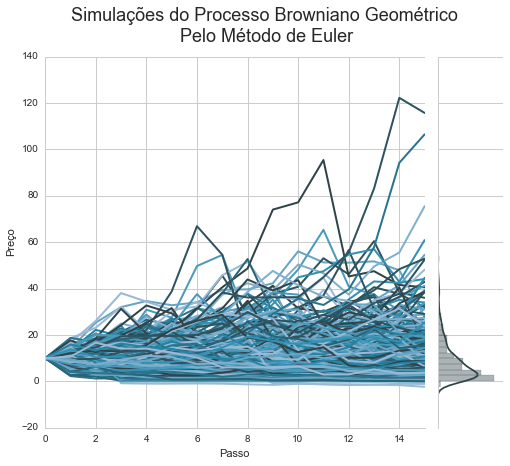

In [74]:
plot_simulations(df,
                 u"Simulações do Processo Browniano Geométrico\n Pelo Método de Euler",
                 d_param["f_steps"])

In [75]:
# mostra resumo estatistico do ultimo valor das simulacoes
df_descr = pd.DataFrame(df.iloc[-1, :].describe()).T
df_descr.index = ["values"]
df_descr

,count,mean,std,min,25%,50%,75%,max
values,500,9.731157,12.119165,-2.321259,2.41906,6.290893,12.199462,115.701398


Bla bla

### 3.4. Enfim, o apreçamento dos derivativos

Assumindo que todas as opções são do tipo Européia (só podem ser exercidas no vencimento) e não dependem da trajetória do ativo base, e utilizando o mundo neutro a risco descrito acima, preciso apenas trazer a valor presente o valor das opções em seus vencimentos. Considerando uma taxa de juros livre de risco $r$ constante no período, fico com

$V_T = e^{-r(T-t)} E^{\tilde{P}}_{t}[V(T, S_T)]$

Aplicando esta fórmula e a dinâmica neutra a risco do ativo base ao payoff do **contrato log**, segue que

\begin{equation}
    \begin{aligned}
    V_T &= V(T, S_T) = ln(S_T) \\
    &= e^{-r(T-t)} E^{\tilde{P}}_{t}[V(T, S_T)] \\
    &= e^{-r(T-t)} E^{\tilde{P}}_{t}[ln(S_T)] \\
    &= e^{-r(T-t)} E^{\tilde{P}}_{t}[ln(S_t \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}})] \\
    &= e^{-r(T-t)} E^{\tilde{P}}_{t}[ln(S_t)  \cdot \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}]
    \end{aligned}
\end{equation}

Como $E^{\tilde{P}}_t [\tilde{W_t}] = 0$, a equação de precificação e o [delta](http://www.investopedia.com/articles/optioninvestor/03/021403.asp) da opção (sua sensibilidade em relação à $S_t$) ficam sendo:
\begin{equation}
    \begin{aligned}
    V_t &= e^{-r(T-t)} \cdot ln(S_t)  \cdot \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) \\
    \Delta &= \frac{\partial V_t}{\partial S_t} = \frac{e^{-r(T-t)}}{S_t}
    \end{aligned} \\
\end{equation}


In [ ]:
# implementar ...

Agora, precificando o **contrato log quadrático**, tenho que:

\begin{equation}
    \begin{aligned}
    V_T &= V(T, S_T) = (ln(S_T))^2 \\
    &= e^{-r(T-t)} E^{\tilde{P}}_{t}[V(T, S_T)] \\
    &= e^{-r(T-t)} E^{\tilde{P}}_{t}[(ln(S_T))^2] \\
    &= e^{-r(T-t)} E^{\tilde{P}}_{t}[(ln(S_t \cdot e^{ \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t}}))^2] \\
    &= e^{-r(T-t)} E^{\tilde{P}}_{t}[(ln(S_t)  \cdot \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) + \sigma \cdot W^{\tilde{P}}_{T-t})^2]
    \end{aligned}
\end{equation}

Lembrando da propriedade do [quadrado de uma soma](http://planetmath.org/squareofsum), chego que:
\begin{equation}
    \begin{aligned}
    V_T &= e^{-r(T-t)} E^{\tilde{P}}_{t}[(ln(S_t)  \cdot \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t))^2 + 2 \cdot ln(S_t)  \cdot \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t) \cdot \sigma \cdot W^{\tilde{P}}_{T-t} + (\sigma \cdot W^{\tilde{P}}_{T-t})^2]  \\
    \end{aligned}
\end{equation}

Como $E^{\tilde{P}}_t [\tilde{W_t}] = 0$ e $E^{\tilde{P}}_t [\sigma^2 \tilde{W_t}^2] = \sigma^2 (T-t)$, então o delta e a equação ficam sendo:
\begin{equation}
    \begin{aligned}
    V_t &= e^{-r(T-t)} \cdot [(ln(S_t)  \cdot \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t))^2 + \sigma^2 (T-t)] \\
    \Delta &= \frac{\partial V_t}{\partial S_t} = \frac{2e^{-r(T-t)}}{S_t}[(ln(S_t)  \cdot \left (r - \frac{\sigma^2}{2}\right ) \cdot (T - t)]
    \end{aligned}
\end{equation}


In [ ]:
# implementar ...

## 3. Replicando o Portfólio

In [2]:
# importa bibliotecas necessarias
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

Dado que $X \sim N(\mu, \sigma)$, a função geradora de momentos da variável aleatória de $X$ no mundo neutro a risco $E_{t}^{\tilde{P}} (e^{\lambda X}) = e^{\lambda \mu + \tfrac{1}{2} \lambda^{2} \sigma^{2}}$.


## 4. Conclusão

## 5. Últimas Considerações

_Style notebook and change matplotlib defaults_

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [2]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("PuBuGn_d", 10))